In [1]:
from rdkit import Chem
import sys
import os
import useful_rdkit_utils as uru
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
import itertools
import pandas as pd
from collections import Counter
import mols2grid
from tdc.single_pred import ADME
from Filtering_functions import filter_molecules
import glob

In [2]:
# Get the current working directory
current_dir = os.getcwd()
print(current_dir)
# Get the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
print(parent_dir)
# Add the parent directory to sys.path
sys.path.append(parent_dir)

/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/Decompdiff
/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model


Set the default image size

In [3]:
uru.rd_set_image_size(300,300)

### Reading the data from Targetdiff

See if they are valid or not

In [4]:
smi_list = []
with open('combined_smiles_decompdiff.smi') as f:
    for smi in f:
        smi_list.append(smi.strip())
standardized_smiles_list = []
for smi in smi_list:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        standardized_smiles_list.append(Chem.MolToSmiles(mol))

print(len(smi_list))
len(standardized_smiles_list)

884


884

Convert SMILES and name of them to a dataframe

In [5]:
df = pd.DataFrame(standardized_smiles_list, columns=['SMILES'])
df

,SMILES
0,Oc1cccc2ccccc12
1,CC1NCC(C(N)=O)=CC1O
2,C1CCC2NCNCCC2C1
3,c1ccc(-c2nccs2)cc1
4,Oc1ccc2ccccc2c1
...,...
879,Nc1ncnc2n(C3OC(O)C(O)C3COP(=O)(O)OP(=O)(O)O)c=...
880,Nc1ncc2c(n1)N(C1CC(O)C(CO[PH](=O)(O)(O)O[PH](=...
881,CC1CC(CC2CCN3C(=N)C(=O)N=C23)CC1COP(=O)(O)OP(=...
882,CC1OC(C2NCNC3NC(N)NC32)C(OP(=O)(O)OP(=O)(O)O)CC1O


Add an RDKit molecule to the dataframe

In [6]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

Strip salts from the molecule

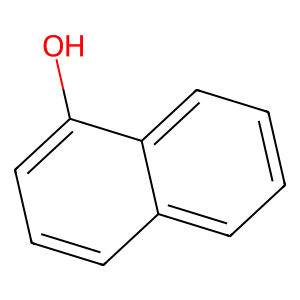

In [7]:
df.mol = df.mol.apply(uru.get_largest_fragment)
df.mol[0]

Instantiate a RingSystemFinder object and find ring systems for the molecules in df

In [8]:
ring_system_finder = uru.RingSystemFinder()
df['ring_sytems'] = df.mol.apply(ring_system_finder.find_ring_systems)
df.ring_sytems

0                    [c1ccc2ccccc2c1]
1                         [C1=CCNCC1]
2                   [C1CCC2NCNCCC2C1]
3                 [c1ccccc1, c1cscn1]
4                    [c1ccc2ccccc2c1]
                    ...              
879      [c1ncnc2[nH]c=2cn1, C1CCOC1]
880        [c1ncc2c(n1)NCC2, C1CCCC1]
881    [C1CCCC1, N=C1C(=O)N=C2CCCN12]
882         [C1CCOCC1, C1NCC2NCNC2N1]
883                        [C1CCNCC1]
Name: ring_sytems, Length: 884, dtype: object

In [9]:
df.ring_sytems.values

array([list(['c1ccc2ccccc2c1']), list(['C1=CCNCC1']),
       list(['C1CCC2NCNCCC2C1']), list(['c1ccccc1', 'c1cscn1']),
       list(['c1ccc2ccccc2c1']), list(['c1ccccc1']),
       list(['C1CNCC2CCNCC2C1']), list(['O=C1N=Cc2ccccc21']),
       list(['c1c[nH]cn1']), list(['C1CCC2NCNC2C1']), list([]), list([]),
       list([]), list([]), list([]), list([]), list([]), list([]),
       list([]), list([]), list(['C1CCCCC1']), list(['C1CCCC1']),
       list(['C1CCCC1']), list(['C1=NCCCC1']), list(['C1=CCCCC1']),
       list(['O=C1CCCCN1']), list(['C1CCCC1']), list(['C=C1CCCCNC1']),
       list(['O=[PH]1OCCC2CC(CO2)CO1']), list(['O=C1CCCC1']),
       list(['C1CCNC1']), list(['c1ccsc1', 'c1nnc[nH]1']),
       list(['c1ccsc1']), list([]), list(['c1cnoc1', 'C1CCNC1']),
       list(['c1cnoc1', 'c1cnoc1']), list([]), list(['c1cn[nH]c1']),
       list(['C1CCNC1', 'c1ccsc1']), list(['C=C1N=CC=[S+]1', 'C1COCN1']),
       list(['C1COC2(CO1)CO2']), list(['O=C1CNC2CCOC2C1', 'c1ccccc1']),
       list(['O=C1

See how many times each ring system occurs

In [10]:
ring_system_list = list(itertools.chain.from_iterable(df.ring_sytems.values))
ring_count_df = pd.DataFrame(Counter(ring_system_list).items(),columns=["SMILES","Count"]) ### Convert a dictionary to a DataFrame.
ring_count_df.sort_values("Count",ascending=False,inplace=True)
ring_count_df

,SMILES,Count
3,c1ccccc1,270
29,C1CCOC1,65
10,C1CCCC1,56
31,C1CCCCCC1,51
17,C1CCNC1,42
...,...,...
15,O=[PH]1OCCC2CC(CO2)CO1,1
19,c1nnc[nH]1,1
22,C=C1N=CC=[S+]1,1
24,C1COC2(CO1)CO2,1


View the ring system frequencies

In [11]:
mols2grid.display(ring_count_df,subset=["img","Count"])

MolGridWidget()

The RingSystemLookup object has a dictionary of how many times each ring system occurs in the ChEMBL database.  We can use this object to evaluate the molecules in df.

In [12]:
ring_system_lookup = uru.RingSystemLookup.default()
res = df.mol.apply(ring_system_lookup.process_mol)

In [13]:
res

0                         [(c1ccc2ccccc2c1, 49955)]
1                               [(C1=CCNCC1, 5040)]
2                            [(C1CCC2NCNCCC2C1, 0)]
3           [(c1ccccc1, 2260082), (c1cscn1, 61036)]
4                         [(c1ccc2ccccc2c1, 49955)]
                           ...                     
879      [(c1ncnc2[nH]c=2cn1, 0), (C1CCOC1, 47269)]
880      [(c1ncc2c(n1)NCC2, 814), (C1CCCC1, 30433)]
881    [(C1CCCC1, 30433), (N=C1C(=O)N=C2CCCN12, 0)]
882         [(C1CCOCC1, 64272), (C1NCC2NCNC2N1, 0)]
883                            [(C1CCNCC1, 174309)]
Name: mol, Length: 884, dtype: object

In [14]:
df[['min_ring','min_freq']] = res.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq
0,Oc1cccc2ccccc12,<rdkit.Chem.rdchem.Mol object at 0x774e35f7e110>,[c1ccc2ccccc2c1],c1ccc2ccccc2c1,49955
1,CC1NCC(C(N)=O)=CC1O,<rdkit.Chem.rdchem.Mol object at 0x774e35f7e260>,[C1=CCNCC1],C1=CCNCC1,5040
2,C1CCC2NCNCCC2C1,<rdkit.Chem.rdchem.Mol object at 0x774e35f7e2d0>,[C1CCC2NCNCCC2C1],C1CCC2NCNCCC2C1,0
3,c1ccc(-c2nccs2)cc1,<rdkit.Chem.rdchem.Mol object at 0x774e35f7e340>,"[c1ccccc1, c1cscn1]",c1cscn1,61036
4,Oc1ccc2ccccc2c1,<rdkit.Chem.rdchem.Mol object at 0x774e35f7e3b0>,[c1ccc2ccccc2c1],c1ccc2ccccc2c1,49955
...,...,...,...,...,...
879,Nc1ncnc2n(C3OC(O)C(O)C3COP(=O)(O)OP(=O)(O)O)c=...,<rdkit.Chem.rdchem.Mol object at 0x774e35f965e0>,"[c1ncnc2[nH]c=2cn1, C1CCOC1]",c1ncnc2[nH]c=2cn1,0
880,Nc1ncc2c(n1)N(C1CC(O)C(CO[PH](=O)(O)(O)O[PH](=...,<rdkit.Chem.rdchem.Mol object at 0x774e35f96650>,"[c1ncc2c(n1)NCC2, C1CCCC1]",c1ncc2c(n1)NCC2,814
881,CC1CC(CC2CCN3C(=N)C(=O)N=C23)CC1COP(=O)(O)OP(=...,<rdkit.Chem.rdchem.Mol object at 0x774e35f966c0>,"[C1CCCC1, N=C1C(=O)N=C2CCCN12]",N=C1C(=O)N=C2CCCN12,0
882,CC1OC(C2NCNC3NC(N)NC32)C(OP(=O)(O)OP(=O)(O)O)CC1O,<rdkit.Chem.rdchem.Mol object at 0x774e35f96730>,"[C1CCOCC1, C1NCC2NCNC2N1]",C1NCC2NCNC2N1,0


In [15]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

### Check how many molecules are unique the ring frequency of them

How many molecules are unique using inChI?

In [16]:
df['inchi'] = df.mol.apply(Chem.MolToInchi)
df = df.drop_duplicates("inchi", keep="first", ignore_index=True)
df

[20:41:12] WARNING: Omitted undefined stereo

[20:41:12] WARNING: Omitted undefined stereo

[20:41:12] WARNING: Omitted undefined stereo

[20:41:12] WARNING: Omitted undefined stereo

[20:41:12] WARNING: Omitted undefined stereo

[20:41:12] WARNING: Omitted undefined stereo

[20:41:12] WARNING: Omitted undefined stereo

[20:41:12] WARNING: Omitted undefined stereo

[20:41:12] WARNING: Omitted undefined stereo

[20:41:12] WARNING: Omitted undefined stereo

[20:41:12] WARNING: Omitted undefined stereo

[20:41:12] WARNING: Omitted undefined stereo

[20:41:12] WARNING: Omitted undefined stereo

[20:41:12] WARNING: Omitted undefined stereo

[20:41:12] WARNING: Omitted undefined stereo

[20:41:12] WARNING: Omitted undefined stereo

[20:41:12] WARNING: Omitted undefined stereo

[20:41:12] WARNING: Omitted undefined stereo

[20:41:12] WARNING: Omitted undefined stereo

[20:41:12] WARNING: Omitted undefined stereo

[20:41:12] WARNING: Omitted undefined stereo

[20:41:12] WARNING: Omitted undefi

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,Oc1cccc2ccccc12,<rdkit.Chem.rdchem.Mol object at 0x774e35f7e110>,[c1ccc2ccccc2c1],c1ccc2ccccc2c1,49955,InChI=1S/C10H8O/c11-10-7-3-5-8-4-1-2-6-9(8)10/...
1,CC1NCC(C(N)=O)=CC1O,<rdkit.Chem.rdchem.Mol object at 0x774e35f7e260>,[C1=CCNCC1],C1=CCNCC1,5040,InChI=1S/C7H12N2O2/c1-4-6(10)2-5(3-9-4)7(8)11/...
2,C1CCC2NCNCCC2C1,<rdkit.Chem.rdchem.Mol object at 0x774e35f7e2d0>,[C1CCC2NCNCCC2C1],C1CCC2NCNCCC2C1,0,InChI=1S/C9H18N2/c1-2-4-9-8(3-1)5-6-10-7-11-9/...
3,c1ccc(-c2nccs2)cc1,<rdkit.Chem.rdchem.Mol object at 0x774e35f7e340>,"[c1ccccc1, c1cscn1]",c1cscn1,61036,InChI=1S/C9H7NS/c1-2-4-8(5-3-1)9-10-6-7-11-9/h...
4,Oc1ccc2ccccc2c1,<rdkit.Chem.rdchem.Mol object at 0x774e35f7e3b0>,[c1ccc2ccccc2c1],c1ccc2ccccc2c1,49955,InChI=1S/C10H8O/c11-10-6-5-8-3-1-2-4-9(8)7-10/...
...,...,...,...,...,...,...
849,Nc1ncnc2n(C3OC(O)C(O)C3COP(=O)(O)OP(=O)(O)O)c=...,<rdkit.Chem.rdchem.Mol object at 0x774e35f965e0>,"[c1ncnc2[nH]c=2cn1, C1CCOC1]",c1ncnc2[nH]c=2cn1,0,InChI=1S/C10H15N5O10P2/c11-10-12-1-5-7(13-3-14...
850,Nc1ncc2c(n1)N(C1CC(O)C(CO[PH](=O)(O)(O)O[PH](=...,<rdkit.Chem.rdchem.Mol object at 0x774e35f96650>,"[c1ncc2c(n1)NCC2, C1CCCC1]",c1ncc2c(n1)NCC2,814,InChI=1S/C12H21N4O9P2/c13-12-14-4-6-1-2-16(11(...
851,CC1CC(CC2CCN3C(=N)C(=O)N=C23)CC1COP(=O)(O)OP(=...,<rdkit.Chem.rdchem.Mol object at 0x774e35f966c0>,"[C1CCCC1, N=C1C(=O)N=C2CCCN12]",N=C1C(=O)N=C2CCCN12,0,InChI=1S/C14H23N3O8P2/c1-8-4-9(5-10-2-3-17-12(...
852,CC1OC(C2NCNC3NC(N)NC32)C(OP(=O)(O)OP(=O)(O)O)CC1O,<rdkit.Chem.rdchem.Mol object at 0x774e35f96730>,"[C1CCOCC1, C1NCC2NCNC2N1]",C1NCC2NCNC2N1,0,"InChI=1S/C11H25N5O9P2/c1-4-5(17)2-6(24-27(21,2..."


How many molecules contains ring structure?

In [17]:
df_ring = df[df.min_freq != -1]
df_ring

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,Oc1cccc2ccccc12,<rdkit.Chem.rdchem.Mol object at 0x774e35f7e110>,[c1ccc2ccccc2c1],c1ccc2ccccc2c1,49955,InChI=1S/C10H8O/c11-10-7-3-5-8-4-1-2-6-9(8)10/...
1,CC1NCC(C(N)=O)=CC1O,<rdkit.Chem.rdchem.Mol object at 0x774e35f7e260>,[C1=CCNCC1],C1=CCNCC1,5040,InChI=1S/C7H12N2O2/c1-4-6(10)2-5(3-9-4)7(8)11/...
2,C1CCC2NCNCCC2C1,<rdkit.Chem.rdchem.Mol object at 0x774e35f7e2d0>,[C1CCC2NCNCCC2C1],C1CCC2NCNCCC2C1,0,InChI=1S/C9H18N2/c1-2-4-9-8(3-1)5-6-10-7-11-9/...
3,c1ccc(-c2nccs2)cc1,<rdkit.Chem.rdchem.Mol object at 0x774e35f7e340>,"[c1ccccc1, c1cscn1]",c1cscn1,61036,InChI=1S/C9H7NS/c1-2-4-8(5-3-1)9-10-6-7-11-9/h...
4,Oc1ccc2ccccc2c1,<rdkit.Chem.rdchem.Mol object at 0x774e35f7e3b0>,[c1ccc2ccccc2c1],c1ccc2ccccc2c1,49955,InChI=1S/C10H8O/c11-10-6-5-8-3-1-2-4-9(8)7-10/...
...,...,...,...,...,...,...
849,Nc1ncnc2n(C3OC(O)C(O)C3COP(=O)(O)OP(=O)(O)O)c=...,<rdkit.Chem.rdchem.Mol object at 0x774e35f965e0>,"[c1ncnc2[nH]c=2cn1, C1CCOC1]",c1ncnc2[nH]c=2cn1,0,InChI=1S/C10H15N5O10P2/c11-10-12-1-5-7(13-3-14...
850,Nc1ncc2c(n1)N(C1CC(O)C(CO[PH](=O)(O)(O)O[PH](=...,<rdkit.Chem.rdchem.Mol object at 0x774e35f96650>,"[c1ncc2c(n1)NCC2, C1CCCC1]",c1ncc2c(n1)NCC2,814,InChI=1S/C12H21N4O9P2/c13-12-14-4-6-1-2-16(11(...
851,CC1CC(CC2CCN3C(=N)C(=O)N=C23)CC1COP(=O)(O)OP(=...,<rdkit.Chem.rdchem.Mol object at 0x774e35f966c0>,"[C1CCCC1, N=C1C(=O)N=C2CCCN12]",N=C1C(=O)N=C2CCCN12,0,InChI=1S/C14H23N3O8P2/c1-8-4-9(5-10-2-3-17-12(...
852,CC1OC(C2NCNC3NC(N)NC32)C(OP(=O)(O)OP(=O)(O)O)CC1O,<rdkit.Chem.rdchem.Mol object at 0x774e35f96730>,"[C1CCOCC1, C1NCC2NCNC2N1]",C1NCC2NCNC2N1,0,"InChI=1S/C11H25N5O9P2/c1-4-5(17)2-6(24-27(21,2..."


In [18]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,Oc1cccc2ccccc12,<rdkit.Chem.rdchem.Mol object at 0x774e35f7e110>,[c1ccc2ccccc2c1],c1ccc2ccccc2c1,49955,InChI=1S/C10H8O/c11-10-7-3-5-8-4-1-2-6-9(8)10/...
1,CC1NCC(C(N)=O)=CC1O,<rdkit.Chem.rdchem.Mol object at 0x774e35f7e260>,[C1=CCNCC1],C1=CCNCC1,5040,InChI=1S/C7H12N2O2/c1-4-6(10)2-5(3-9-4)7(8)11/...
3,c1ccc(-c2nccs2)cc1,<rdkit.Chem.rdchem.Mol object at 0x774e35f7e340>,"[c1ccccc1, c1cscn1]",c1cscn1,61036,InChI=1S/C9H7NS/c1-2-4-8(5-3-1)9-10-6-7-11-9/h...
4,Oc1ccc2ccccc2c1,<rdkit.Chem.rdchem.Mol object at 0x774e35f7e3b0>,[c1ccc2ccccc2c1],c1ccc2ccccc2c1,49955,InChI=1S/C10H8O/c11-10-6-5-8-3-1-2-4-9(8)7-10/...
5,N=C(N)Oc1ccccc1N,<rdkit.Chem.rdchem.Mol object at 0x774e35f7e420>,[c1ccccc1],c1ccccc1,2260082,InChI=1S/C7H9N3O/c8-5-3-1-2-4-6(5)11-7(9)10/h1...
...,...,...,...,...,...,...
845,NC(C(=O)O)P(=O)(O)OC1CNC(CCOP(=O)(O)O)C1O,<rdkit.Chem.rdchem.Mol object at 0x774e35f96420>,[C1CCNC1],C1CCNC1,112428,"InChI=1S/C8H18N2O10P2/c9-7(8(12)13)21(14,15)20..."
847,Cc1ncn(C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)c2ncn...,<rdkit.Chem.rdchem.Mol object at 0x774e35f96490>,"[c1nc2cnc[nH]c-2n1, C1CCOC1]",c1nc2cnc[nH]c-2n1,24411,InChI=1S/C11H16N4O10P2/c1-5-7-10(13-3-12-7)15(...
848,Nc1ncn(C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)c2ncn...,<rdkit.Chem.rdchem.Mol object at 0x774e35f96570>,"[c1nc2cnc[nH]c-2n1, C1CCOC1]",c1nc2cnc[nH]c-2n1,24411,InChI=1S/C10H15N5O10P2/c11-8-5-9(13-2-12-5)15(...
850,Nc1ncc2c(n1)N(C1CC(O)C(CO[PH](=O)(O)(O)O[PH](=...,<rdkit.Chem.rdchem.Mol object at 0x774e35f96650>,"[c1ncc2c(n1)NCC2, C1CCCC1]",c1ncc2c(n1)NCC2,814,InChI=1S/C12H21N4O9P2/c13-12-14-4-6-1-2-16(11(...


### How many of them could pass PAINS filter?

Get a list of rules

In [19]:
reos = uru.REOS()
reos.get_available_rule_sets()

array(['Glaxo', 'Dundee', 'BMS', 'PAINS', 'SureChEMBL', 'MLSMR',
       'Inpharmatica', 'LINT'], dtype=object)

Get the currently active rule sets

In [20]:
reos.get_active_rule_sets()

array(['Glaxo'], dtype=object)

Set active rule set to PAINS

In [21]:
reos.set_active_rule_sets(['PAINS'])
reos.get_active_rule_sets()

array(['PAINS'], dtype=object)

Apply PAINS filter to unique mols

In [22]:
reos.pandas_mols(df.mol)

  0%|          | 0/854 [00:00<?, ?it/s]

,rule_set_name,description
0,ok,ok
1,ok,ok
2,ok,ok
3,ok,ok
4,ok,ok
...,...,...
849,ok,ok
850,ok,ok
851,ok,ok
852,ok,ok


In [23]:
df_PAINS_filter = pd.concat([df, reos.pandas_mols(df.mol)], axis=1)
df_PAINS_filter = df_PAINS_filter[df_PAINS_filter.description == 'ok']
df_PAINS_filter

  0%|          | 0/854 [00:00<?, ?it/s]

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,rule_set_name,description
0,Oc1cccc2ccccc12,<rdkit.Chem.rdchem.Mol object at 0x774e35f7e110>,[c1ccc2ccccc2c1],c1ccc2ccccc2c1,49955,InChI=1S/C10H8O/c11-10-7-3-5-8-4-1-2-6-9(8)10/...,ok,ok
1,CC1NCC(C(N)=O)=CC1O,<rdkit.Chem.rdchem.Mol object at 0x774e35f7e260>,[C1=CCNCC1],C1=CCNCC1,5040,InChI=1S/C7H12N2O2/c1-4-6(10)2-5(3-9-4)7(8)11/...,ok,ok
2,C1CCC2NCNCCC2C1,<rdkit.Chem.rdchem.Mol object at 0x774e35f7e2d0>,[C1CCC2NCNCCC2C1],C1CCC2NCNCCC2C1,0,InChI=1S/C9H18N2/c1-2-4-9-8(3-1)5-6-10-7-11-9/...,ok,ok
3,c1ccc(-c2nccs2)cc1,<rdkit.Chem.rdchem.Mol object at 0x774e35f7e340>,"[c1ccccc1, c1cscn1]",c1cscn1,61036,InChI=1S/C9H7NS/c1-2-4-8(5-3-1)9-10-6-7-11-9/h...,ok,ok
4,Oc1ccc2ccccc2c1,<rdkit.Chem.rdchem.Mol object at 0x774e35f7e3b0>,[c1ccc2ccccc2c1],c1ccc2ccccc2c1,49955,InChI=1S/C10H8O/c11-10-6-5-8-3-1-2-4-9(8)7-10/...,ok,ok
...,...,...,...,...,...,...,...,...
849,Nc1ncnc2n(C3OC(O)C(O)C3COP(=O)(O)OP(=O)(O)O)c=...,<rdkit.Chem.rdchem.Mol object at 0x774e35f965e0>,"[c1ncnc2[nH]c=2cn1, C1CCOC1]",c1ncnc2[nH]c=2cn1,0,InChI=1S/C10H15N5O10P2/c11-10-12-1-5-7(13-3-14...,ok,ok
850,Nc1ncc2c(n1)N(C1CC(O)C(CO[PH](=O)(O)(O)O[PH](=...,<rdkit.Chem.rdchem.Mol object at 0x774e35f96650>,"[c1ncc2c(n1)NCC2, C1CCCC1]",c1ncc2c(n1)NCC2,814,InChI=1S/C12H21N4O9P2/c13-12-14-4-6-1-2-16(11(...,ok,ok
851,CC1CC(CC2CCN3C(=N)C(=O)N=C23)CC1COP(=O)(O)OP(=...,<rdkit.Chem.rdchem.Mol object at 0x774e35f966c0>,"[C1CCCC1, N=C1C(=O)N=C2CCCN12]",N=C1C(=O)N=C2CCCN12,0,InChI=1S/C14H23N3O8P2/c1-8-4-9(5-10-2-3-17-12(...,ok,ok
852,CC1OC(C2NCNC3NC(N)NC32)C(OP(=O)(O)OP(=O)(O)O)CC1O,<rdkit.Chem.rdchem.Mol object at 0x774e35f96730>,"[C1CCOCC1, C1NCC2NCNC2N1]",C1NCC2NCNC2N1,0,"InChI=1S/C11H25N5O9P2/c1-4-5(17)2-6(24-27(21,2...",ok,ok


Test all filters from rd_filters

In [24]:
rd_filters = ['Glaxo', 'Dundee', 'BMS', 'SureChEMBL', 'MLSMR', 'Inpharmatica', 'LINT']
for filter in rd_filters:
    reos.set_active_rule_sets([filter])
    new_df = reos.pandas_mols(df.mol)
    print(filter, len(new_df[new_df.description == "ok"])/len(new_df), reos.get_active_rule_sets(), len(new_df[new_df.description == "ok"]))

  0%|          | 0/854 [00:00<?, ?it/s]

Glaxo 0.8149882903981265 ['Glaxo'] 696


  0%|          | 0/854 [00:00<?, ?it/s]

Dundee 0.3758782201405152 ['Dundee'] 321


  0%|          | 0/854 [00:00<?, ?it/s]

BMS 0.6639344262295082 ['BMS'] 567


  0%|          | 0/854 [00:00<?, ?it/s]

SureChEMBL 0.6885245901639344 ['SureChEMBL'] 588


  0%|          | 0/854 [00:00<?, ?it/s]

MLSMR 0.36533957845433257 ['MLSMR'] 312


  0%|          | 0/854 [00:00<?, ?it/s]

Inpharmatica 0.7459016393442623 ['Inpharmatica'] 637


  0%|          | 0/854 [00:00<?, ?it/s]

LINT 0.5152224824355972 ['LINT'] 440


### How many of them could pass filters suggested by Dr.Reymond?

In [24]:
df['Reymond'] = df.mol.apply(filter_molecules)
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond
0,Oc1cccc2ccccc12,<rdkit.Chem.rdchem.Mol object at 0x72fee1b8e0a0>,[c1ccc2ccccc2c1],c1ccc2ccccc2c1,49955,InChI=1S/C10H8O/c11-10-7-3-5-8-4-1-2-6-9(8)10/...,True
1,CC1NCC(C(N)=O)=CC1O,<rdkit.Chem.rdchem.Mol object at 0x72fee1b8e1f0>,[C1=CCNCC1],C1=CCNCC1,5040,InChI=1S/C7H12N2O2/c1-4-6(10)2-5(3-9-4)7(8)11/...,True
2,C1CCC2NCNCCC2C1,<rdkit.Chem.rdchem.Mol object at 0x72fee1b8e260>,[C1CCC2NCNCCC2C1],C1CCC2NCNCCC2C1,0,InChI=1S/C9H18N2/c1-2-4-9-8(3-1)5-6-10-7-11-9/...,True
3,c1ccc(-c2nccs2)cc1,<rdkit.Chem.rdchem.Mol object at 0x72fee1b8e2d0>,"[c1ccccc1, c1cscn1]",c1cscn1,61036,InChI=1S/C9H7NS/c1-2-4-8(5-3-1)9-10-6-7-11-9/h...,True
4,Oc1ccc2ccccc2c1,<rdkit.Chem.rdchem.Mol object at 0x72fee1b8e340>,[c1ccc2ccccc2c1],c1ccc2ccccc2c1,49955,InChI=1S/C10H8O/c11-10-6-5-8-3-1-2-4-9(8)7-10/...,True
...,...,...,...,...,...,...,...
849,Nc1ncnc2n(C3OC(O)C(O)C3COP(=O)(O)OP(=O)(O)O)c=...,<rdkit.Chem.rdchem.Mol object at 0x72fee1baa500>,"[c1ncnc2[nH]c=2cn1, C1CCOC1]",c1ncnc2[nH]c=2cn1,0,InChI=1S/C10H15N5O10P2/c11-10-12-1-5-7(13-3-14...,False
850,Nc1ncc2c(n1)N(C1CC(O)C(CO[PH](=O)(O)(O)O[PH](=...,<rdkit.Chem.rdchem.Mol object at 0x72fee1baa570>,"[c1ncc2c(n1)NCC2, C1CCCC1]",c1ncc2c(n1)NCC2,814,InChI=1S/C12H21N4O9P2/c13-12-14-4-6-1-2-16(11(...,True
851,CC1CC(CC2CCN3C(=N)C(=O)N=C23)CC1COP(=O)(O)OP(=...,<rdkit.Chem.rdchem.Mol object at 0x72fee1baa5e0>,"[C1CCCC1, N=C1C(=O)N=C2CCCN12]",N=C1C(=O)N=C2CCCN12,0,InChI=1S/C14H23N3O8P2/c1-8-4-9(5-10-2-3-17-12(...,True
852,CC1OC(C2NCNC3NC(N)NC32)C(OP(=O)(O)OP(=O)(O)O)CC1O,<rdkit.Chem.rdchem.Mol object at 0x72fee1baa650>,"[C1CCOCC1, C1NCC2NCNC2N1]",C1NCC2NCNC2N1,0,"InChI=1S/C11H25N5O9P2/c1-4-5(17)2-6(24-27(21,2...",True


In [25]:
df_Reymond_filter = df[df.Reymond == True]
df_Reymond_filter

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond
0,Oc1cccc2ccccc12,<rdkit.Chem.rdchem.Mol object at 0x72fee1b8e0a0>,[c1ccc2ccccc2c1],c1ccc2ccccc2c1,49955,InChI=1S/C10H8O/c11-10-7-3-5-8-4-1-2-6-9(8)10/...,True
1,CC1NCC(C(N)=O)=CC1O,<rdkit.Chem.rdchem.Mol object at 0x72fee1b8e1f0>,[C1=CCNCC1],C1=CCNCC1,5040,InChI=1S/C7H12N2O2/c1-4-6(10)2-5(3-9-4)7(8)11/...,True
2,C1CCC2NCNCCC2C1,<rdkit.Chem.rdchem.Mol object at 0x72fee1b8e260>,[C1CCC2NCNCCC2C1],C1CCC2NCNCCC2C1,0,InChI=1S/C9H18N2/c1-2-4-9-8(3-1)5-6-10-7-11-9/...,True
3,c1ccc(-c2nccs2)cc1,<rdkit.Chem.rdchem.Mol object at 0x72fee1b8e2d0>,"[c1ccccc1, c1cscn1]",c1cscn1,61036,InChI=1S/C9H7NS/c1-2-4-8(5-3-1)9-10-6-7-11-9/h...,True
4,Oc1ccc2ccccc2c1,<rdkit.Chem.rdchem.Mol object at 0x72fee1b8e340>,[c1ccc2ccccc2c1],c1ccc2ccccc2c1,49955,InChI=1S/C10H8O/c11-10-6-5-8-3-1-2-4-9(8)7-10/...,True
...,...,...,...,...,...,...,...
848,Nc1ncn(C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)c2ncn...,<rdkit.Chem.rdchem.Mol object at 0x72fee1baa490>,"[c1nc2cnc[nH]c-2n1, C1CCOC1]",c1nc2cnc[nH]c-2n1,24411,InChI=1S/C10H15N5O10P2/c11-8-5-9(13-2-12-5)15(...,True
850,Nc1ncc2c(n1)N(C1CC(O)C(CO[PH](=O)(O)(O)O[PH](=...,<rdkit.Chem.rdchem.Mol object at 0x72fee1baa570>,"[c1ncc2c(n1)NCC2, C1CCCC1]",c1ncc2c(n1)NCC2,814,InChI=1S/C12H21N4O9P2/c13-12-14-4-6-1-2-16(11(...,True
851,CC1CC(CC2CCN3C(=N)C(=O)N=C23)CC1COP(=O)(O)OP(=...,<rdkit.Chem.rdchem.Mol object at 0x72fee1baa5e0>,"[C1CCCC1, N=C1C(=O)N=C2CCCN12]",N=C1C(=O)N=C2CCCN12,0,InChI=1S/C14H23N3O8P2/c1-8-4-9(5-10-2-3-17-12(...,True
852,CC1OC(C2NCNC3NC(N)NC32)C(OP(=O)(O)OP(=O)(O)O)CC1O,<rdkit.Chem.rdchem.Mol object at 0x72fee1baa650>,"[C1CCOCC1, C1NCC2NCNC2N1]",C1NCC2NCNC2N1,0,"InChI=1S/C11H25N5O9P2/c1-4-5(17)2-6(24-27(21,2...",True


### How many of them could pass RO5?

In [26]:
def passes_rule_of_five(smiles):
    """Determine if a molecule passes Lipinski's Rule of Five."""
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        hbd = Descriptors.NumHDonors(mol)  # Hydrogen bond donors
        hba = Descriptors.NumHAcceptors(mol)  # Hydrogen bond acceptors
        mw = Descriptors.MolWt(mol)  # Molecular weight
        logp = Descriptors.MolLogP(mol)  # LogP
        
        # Check Lipinski's Rule of Five criteria
        if hbd <= 5 and hba <= 10 and mw <= 500 and logp <= 5:
            return True
    return False

df['Lipinski'] = df.SMILES.apply(passes_rule_of_five)
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,Oc1cccc2ccccc12,<rdkit.Chem.rdchem.Mol object at 0x72fee1b8e0a0>,[c1ccc2ccccc2c1],c1ccc2ccccc2c1,49955,InChI=1S/C10H8O/c11-10-7-3-5-8-4-1-2-6-9(8)10/...,True,True
1,CC1NCC(C(N)=O)=CC1O,<rdkit.Chem.rdchem.Mol object at 0x72fee1b8e1f0>,[C1=CCNCC1],C1=CCNCC1,5040,InChI=1S/C7H12N2O2/c1-4-6(10)2-5(3-9-4)7(8)11/...,True,True
2,C1CCC2NCNCCC2C1,<rdkit.Chem.rdchem.Mol object at 0x72fee1b8e260>,[C1CCC2NCNCCC2C1],C1CCC2NCNCCC2C1,0,InChI=1S/C9H18N2/c1-2-4-9-8(3-1)5-6-10-7-11-9/...,True,True
3,c1ccc(-c2nccs2)cc1,<rdkit.Chem.rdchem.Mol object at 0x72fee1b8e2d0>,"[c1ccccc1, c1cscn1]",c1cscn1,61036,InChI=1S/C9H7NS/c1-2-4-8(5-3-1)9-10-6-7-11-9/h...,True,True
4,Oc1ccc2ccccc2c1,<rdkit.Chem.rdchem.Mol object at 0x72fee1b8e340>,[c1ccc2ccccc2c1],c1ccc2ccccc2c1,49955,InChI=1S/C10H8O/c11-10-6-5-8-3-1-2-4-9(8)7-10/...,True,True
...,...,...,...,...,...,...,...,...
849,Nc1ncnc2n(C3OC(O)C(O)C3COP(=O)(O)OP(=O)(O)O)c=...,<rdkit.Chem.rdchem.Mol object at 0x72fee1baa500>,"[c1ncnc2[nH]c=2cn1, C1CCOC1]",c1ncnc2[nH]c=2cn1,0,InChI=1S/C10H15N5O10P2/c11-10-12-1-5-7(13-3-14...,False,False
850,Nc1ncc2c(n1)N(C1CC(O)C(CO[PH](=O)(O)(O)O[PH](=...,<rdkit.Chem.rdchem.Mol object at 0x72fee1baa570>,"[c1ncc2c(n1)NCC2, C1CCCC1]",c1ncc2c(n1)NCC2,814,InChI=1S/C12H21N4O9P2/c13-12-14-4-6-1-2-16(11(...,True,False
851,CC1CC(CC2CCN3C(=N)C(=O)N=C23)CC1COP(=O)(O)OP(=...,<rdkit.Chem.rdchem.Mol object at 0x72fee1baa5e0>,"[C1CCCC1, N=C1C(=O)N=C2CCCN12]",N=C1C(=O)N=C2CCCN12,0,InChI=1S/C14H23N3O8P2/c1-8-4-9(5-10-2-3-17-12(...,True,True
852,CC1OC(C2NCNC3NC(N)NC32)C(OP(=O)(O)OP(=O)(O)O)CC1O,<rdkit.Chem.rdchem.Mol object at 0x72fee1baa650>,"[C1CCOCC1, C1NCC2NCNC2N1]",C1NCC2NCNC2N1,0,"InChI=1S/C11H25N5O9P2/c1-4-5(17)2-6(24-27(21,2...",True,False


In [27]:
df_Lipinski_filter = df[df.Lipinski == True]
df_Lipinski_filter

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,Oc1cccc2ccccc12,<rdkit.Chem.rdchem.Mol object at 0x72fee1b8e0a0>,[c1ccc2ccccc2c1],c1ccc2ccccc2c1,49955,InChI=1S/C10H8O/c11-10-7-3-5-8-4-1-2-6-9(8)10/...,True,True
1,CC1NCC(C(N)=O)=CC1O,<rdkit.Chem.rdchem.Mol object at 0x72fee1b8e1f0>,[C1=CCNCC1],C1=CCNCC1,5040,InChI=1S/C7H12N2O2/c1-4-6(10)2-5(3-9-4)7(8)11/...,True,True
2,C1CCC2NCNCCC2C1,<rdkit.Chem.rdchem.Mol object at 0x72fee1b8e260>,[C1CCC2NCNCCC2C1],C1CCC2NCNCCC2C1,0,InChI=1S/C9H18N2/c1-2-4-9-8(3-1)5-6-10-7-11-9/...,True,True
3,c1ccc(-c2nccs2)cc1,<rdkit.Chem.rdchem.Mol object at 0x72fee1b8e2d0>,"[c1ccccc1, c1cscn1]",c1cscn1,61036,InChI=1S/C9H7NS/c1-2-4-8(5-3-1)9-10-6-7-11-9/h...,True,True
4,Oc1ccc2ccccc2c1,<rdkit.Chem.rdchem.Mol object at 0x72fee1b8e340>,[c1ccc2ccccc2c1],c1ccc2ccccc2c1,49955,InChI=1S/C10H8O/c11-10-6-5-8-3-1-2-4-9(8)7-10/...,True,True
...,...,...,...,...,...,...,...,...
834,OC(COC1CCCC(Cl)C(F)C1)Cc1cccnc1,<rdkit.Chem.rdchem.Mol object at 0x72fee1ba9e70>,"[C1CCCCCC1, c1ccncc1]",C1CCCCCC1,2594,InChI=1S/C15H21ClFNO2/c16-14-5-1-4-13(8-15(14)...,True,True
835,CN(C(=O)NC1CCCC(C)(C)C1)C1CCCOC1=O,<rdkit.Chem.rdchem.Mol object at 0x72fee1ba9ee0>,"[C1CCCCC1, O=C1CCCCO1]",O=C1CCCCO1,583,InChI=1S/C15H26N2O3/c1-15(2)8-4-6-11(10-15)16-...,True,True
836,CN(CCC(=O)O)CCN1CC(O)C(O)C1COP(=O)(O)O,<rdkit.Chem.rdchem.Mol object at 0x72fee1ba9f50>,[C1CCNC1],C1CCNC1,112428,InChI=1S/C11H23N2O8P/c1-12(3-2-10(15)16)4-5-13...,True,True
840,O=C1N=C2N=CC=C2N1C1OC(COP(=O)(O)O)C(O)C1O,<rdkit.Chem.rdchem.Mol object at 0x72fee1baa110>,"[O=C1N=C2N=CC=C2N1, C1CCOC1]",O=C1N=C2N=CC=C2N1,0,"InChI=1S/C10H12N3O8P/c14-6-5(3-20-22(17,18)19)...",True,True


### Molecules' performance in ring systems from ZINC22 database druglike molecules

In [28]:
ring_system_lookup_ZINC22 = uru.RingSystemLookup.from_file("/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC22_rings_system.csv")
res_zinc22 = df.mol.apply(ring_system_lookup_ZINC22.process_mol)
res_zinc22

0                          [(c1ccc2ccccc2c1, 152439190)]
1                               [(C1=CCNCC1, 817040572)]
2                                 [(C1CCC2NCNCCC2C1, 0)]
3       [(c1ccccc1, 21243538754), (c1cscn1, 3866438902)]
4                          [(c1ccc2ccccc2c1, 152439190)]
                             ...                        
849      [(c1ncnc2[nH]c=2cn1, 0), (C1CCOC1, 4151021098)]
850    [(c1ncc2c(n1)NCC2, 103766), (C1CCCC1, 53172176...
851    [(C1CCCC1, 5317217694), (N=C1C(=O)N=C2CCCN12, 0)]
852         [(C1CCOCC1, 2751646430), (C1NCC2NCNC2N1, 0)]
853                            [(C1CCNCC1, 12225942610)]
Name: mol, Length: 854, dtype: object

In [29]:
df[['min_ring','min_freq']] = res_zinc22.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,Oc1cccc2ccccc12,<rdkit.Chem.rdchem.Mol object at 0x72fee1b8e0a0>,[c1ccc2ccccc2c1],c1ccc2ccccc2c1,152439190,InChI=1S/C10H8O/c11-10-7-3-5-8-4-1-2-6-9(8)10/...,True,True
1,CC1NCC(C(N)=O)=CC1O,<rdkit.Chem.rdchem.Mol object at 0x72fee1b8e1f0>,[C1=CCNCC1],C1=CCNCC1,817040572,InChI=1S/C7H12N2O2/c1-4-6(10)2-5(3-9-4)7(8)11/...,True,True
2,C1CCC2NCNCCC2C1,<rdkit.Chem.rdchem.Mol object at 0x72fee1b8e260>,[C1CCC2NCNCCC2C1],C1CCC2NCNCCC2C1,0,InChI=1S/C9H18N2/c1-2-4-9-8(3-1)5-6-10-7-11-9/...,True,True
3,c1ccc(-c2nccs2)cc1,<rdkit.Chem.rdchem.Mol object at 0x72fee1b8e2d0>,"[c1ccccc1, c1cscn1]",c1cscn1,3866438902,InChI=1S/C9H7NS/c1-2-4-8(5-3-1)9-10-6-7-11-9/h...,True,True
4,Oc1ccc2ccccc2c1,<rdkit.Chem.rdchem.Mol object at 0x72fee1b8e340>,[c1ccc2ccccc2c1],c1ccc2ccccc2c1,152439190,InChI=1S/C10H8O/c11-10-6-5-8-3-1-2-4-9(8)7-10/...,True,True
...,...,...,...,...,...,...,...,...
849,Nc1ncnc2n(C3OC(O)C(O)C3COP(=O)(O)OP(=O)(O)O)c=...,<rdkit.Chem.rdchem.Mol object at 0x72fee1baa500>,"[c1ncnc2[nH]c=2cn1, C1CCOC1]",c1ncnc2[nH]c=2cn1,0,InChI=1S/C10H15N5O10P2/c11-10-12-1-5-7(13-3-14...,False,False
850,Nc1ncc2c(n1)N(C1CC(O)C(CO[PH](=O)(O)(O)O[PH](=...,<rdkit.Chem.rdchem.Mol object at 0x72fee1baa570>,"[c1ncc2c(n1)NCC2, C1CCCC1]",c1ncc2c(n1)NCC2,103766,InChI=1S/C12H21N4O9P2/c13-12-14-4-6-1-2-16(11(...,True,False
851,CC1CC(CC2CCN3C(=N)C(=O)N=C23)CC1COP(=O)(O)OP(=...,<rdkit.Chem.rdchem.Mol object at 0x72fee1baa5e0>,"[C1CCCC1, N=C1C(=O)N=C2CCCN12]",N=C1C(=O)N=C2CCCN12,0,InChI=1S/C14H23N3O8P2/c1-8-4-9(5-10-2-3-17-12(...,True,True
852,CC1OC(C2NCNC3NC(N)NC32)C(OP(=O)(O)OP(=O)(O)O)CC1O,<rdkit.Chem.rdchem.Mol object at 0x72fee1baa650>,"[C1CCOCC1, C1NCC2NCNC2N1]",C1NCC2NCNC2N1,0,"InChI=1S/C11H25N5O9P2/c1-4-5(17)2-6(24-27(21,2...",True,False


In [30]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [32]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,Oc1cccc2ccccc12,<rdkit.Chem.rdchem.Mol object at 0x7d7be912d9a0>,[c1ccc2ccccc2c1],c1ccc2ccccc2c1,152439190,InChI=1S/C10H8O/c11-10-7-3-5-8-4-1-2-6-9(8)10/...,True,True
1,CC1NCC(C(N)=O)=CC1O,<rdkit.Chem.rdchem.Mol object at 0x7d7be912daf0>,[C1=CCNCC1],C1=CCNCC1,817040572,InChI=1S/C7H12N2O2/c1-4-6(10)2-5(3-9-4)7(8)11/...,True,True
3,c1ccc(-c2nccs2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7d7be912dbd0>,"[c1ccccc1, c1cscn1]",c1cscn1,3866438902,InChI=1S/C9H7NS/c1-2-4-8(5-3-1)9-10-6-7-11-9/h...,True,True
4,Oc1ccc2ccccc2c1,<rdkit.Chem.rdchem.Mol object at 0x7d7be912dc40>,[c1ccc2ccccc2c1],c1ccc2ccccc2c1,152439190,InChI=1S/C10H8O/c11-10-6-5-8-3-1-2-4-9(8)7-10/...,True,True
5,N=C(N)Oc1ccccc1N,<rdkit.Chem.rdchem.Mol object at 0x7d7be912dcb0>,[c1ccccc1],c1ccccc1,21243538754,InChI=1S/C7H9N3O/c8-5-3-1-2-4-6(5)11-7(9)10/h1...,True,True
...,...,...,...,...,...,...,...,...
845,NC(C(=O)O)P(=O)(O)OC1CNC(CCOP(=O)(O)O)C1O,<rdkit.Chem.rdchem.Mol object at 0x7d7be9145c40>,[C1CCNC1],C1CCNC1,14763048450,"InChI=1S/C8H18N2O10P2/c9-7(8(12)13)21(14,15)20...",True,False
847,Cc1ncn(C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)c2ncn...,<rdkit.Chem.rdchem.Mol object at 0x7d7be9145cb0>,"[c1nc2cnc[nH]c-2n1, C1CCOC1]",c1nc2cnc[nH]c-2n1,72492350,InChI=1S/C11H16N4O10P2/c1-5-7-10(13-3-12-7)15(...,True,False
848,Nc1ncn(C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)c2ncn...,<rdkit.Chem.rdchem.Mol object at 0x7d7be9145d90>,"[c1nc2cnc[nH]c-2n1, C1CCOC1]",c1nc2cnc[nH]c-2n1,72492350,InChI=1S/C10H15N5O10P2/c11-8-5-9(13-2-12-5)15(...,True,False
850,Nc1ncc2c(n1)N(C1CC(O)C(CO[PH](=O)(O)(O)O[PH](=...,<rdkit.Chem.rdchem.Mol object at 0x7d7be9145e70>,"[c1ncc2c(n1)NCC2, C1CCCC1]",c1ncc2c(n1)NCC2,103766,InChI=1S/C12H21N4O9P2/c13-12-14-4-6-1-2-16(11(...,True,False


In [31]:
filtered_df_ring_freq = df[(df.min_freq > 0) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,Oc1cccc2ccccc12,<rdkit.Chem.rdchem.Mol object at 0x72fee1b8e0a0>,[c1ccc2ccccc2c1],c1ccc2ccccc2c1,152439190,InChI=1S/C10H8O/c11-10-7-3-5-8-4-1-2-6-9(8)10/...,True,True
1,CC1NCC(C(N)=O)=CC1O,<rdkit.Chem.rdchem.Mol object at 0x72fee1b8e1f0>,[C1=CCNCC1],C1=CCNCC1,817040572,InChI=1S/C7H12N2O2/c1-4-6(10)2-5(3-9-4)7(8)11/...,True,True
3,c1ccc(-c2nccs2)cc1,<rdkit.Chem.rdchem.Mol object at 0x72fee1b8e2d0>,"[c1ccccc1, c1cscn1]",c1cscn1,3866438902,InChI=1S/C9H7NS/c1-2-4-8(5-3-1)9-10-6-7-11-9/h...,True,True
4,Oc1ccc2ccccc2c1,<rdkit.Chem.rdchem.Mol object at 0x72fee1b8e340>,[c1ccc2ccccc2c1],c1ccc2ccccc2c1,152439190,InChI=1S/C10H8O/c11-10-6-5-8-3-1-2-4-9(8)7-10/...,True,True
5,N=C(N)Oc1ccccc1N,<rdkit.Chem.rdchem.Mol object at 0x72fee1b8e3b0>,[c1ccccc1],c1ccccc1,21243538754,InChI=1S/C7H9N3O/c8-5-3-1-2-4-6(5)11-7(9)10/h1...,True,True
...,...,...,...,...,...,...,...,...
845,NC(C(=O)O)P(=O)(O)OC1CNC(CCOP(=O)(O)O)C1O,<rdkit.Chem.rdchem.Mol object at 0x72fee1baa340>,[C1CCNC1],C1CCNC1,14763048450,"InChI=1S/C8H18N2O10P2/c9-7(8(12)13)21(14,15)20...",True,False
847,Cc1ncn(C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)c2ncn...,<rdkit.Chem.rdchem.Mol object at 0x72fee1baa3b0>,"[c1nc2cnc[nH]c-2n1, C1CCOC1]",c1nc2cnc[nH]c-2n1,72492350,InChI=1S/C11H16N4O10P2/c1-5-7-10(13-3-12-7)15(...,True,False
848,Nc1ncn(C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)c2ncn...,<rdkit.Chem.rdchem.Mol object at 0x72fee1baa490>,"[c1nc2cnc[nH]c-2n1, C1CCOC1]",c1nc2cnc[nH]c-2n1,72492350,InChI=1S/C10H15N5O10P2/c11-8-5-9(13-2-12-5)15(...,True,False
850,Nc1ncc2c(n1)N(C1CC(O)C(CO[PH](=O)(O)(O)O[PH](=...,<rdkit.Chem.rdchem.Mol object at 0x72fee1baa570>,"[c1ncc2c(n1)NCC2, C1CCCC1]",c1ncc2c(n1)NCC2,103766,InChI=1S/C12H21N4O9P2/c13-12-14-4-6-1-2-16(11(...,True,False


In [32]:
filtered_df_ring_freq = df[(df.min_freq > 10) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,Oc1cccc2ccccc12,<rdkit.Chem.rdchem.Mol object at 0x72fee1b8e0a0>,[c1ccc2ccccc2c1],c1ccc2ccccc2c1,152439190,InChI=1S/C10H8O/c11-10-7-3-5-8-4-1-2-6-9(8)10/...,True,True
1,CC1NCC(C(N)=O)=CC1O,<rdkit.Chem.rdchem.Mol object at 0x72fee1b8e1f0>,[C1=CCNCC1],C1=CCNCC1,817040572,InChI=1S/C7H12N2O2/c1-4-6(10)2-5(3-9-4)7(8)11/...,True,True
3,c1ccc(-c2nccs2)cc1,<rdkit.Chem.rdchem.Mol object at 0x72fee1b8e2d0>,"[c1ccccc1, c1cscn1]",c1cscn1,3866438902,InChI=1S/C9H7NS/c1-2-4-8(5-3-1)9-10-6-7-11-9/h...,True,True
4,Oc1ccc2ccccc2c1,<rdkit.Chem.rdchem.Mol object at 0x72fee1b8e340>,[c1ccc2ccccc2c1],c1ccc2ccccc2c1,152439190,InChI=1S/C10H8O/c11-10-6-5-8-3-1-2-4-9(8)7-10/...,True,True
5,N=C(N)Oc1ccccc1N,<rdkit.Chem.rdchem.Mol object at 0x72fee1b8e3b0>,[c1ccccc1],c1ccccc1,21243538754,InChI=1S/C7H9N3O/c8-5-3-1-2-4-6(5)11-7(9)10/h1...,True,True
...,...,...,...,...,...,...,...,...
845,NC(C(=O)O)P(=O)(O)OC1CNC(CCOP(=O)(O)O)C1O,<rdkit.Chem.rdchem.Mol object at 0x72fee1baa340>,[C1CCNC1],C1CCNC1,14763048450,"InChI=1S/C8H18N2O10P2/c9-7(8(12)13)21(14,15)20...",True,False
847,Cc1ncn(C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)c2ncn...,<rdkit.Chem.rdchem.Mol object at 0x72fee1baa3b0>,"[c1nc2cnc[nH]c-2n1, C1CCOC1]",c1nc2cnc[nH]c-2n1,72492350,InChI=1S/C11H16N4O10P2/c1-5-7-10(13-3-12-7)15(...,True,False
848,Nc1ncn(C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)c2ncn...,<rdkit.Chem.rdchem.Mol object at 0x72fee1baa490>,"[c1nc2cnc[nH]c-2n1, C1CCOC1]",c1nc2cnc[nH]c-2n1,72492350,InChI=1S/C10H15N5O10P2/c11-8-5-9(13-2-12-5)15(...,True,False
850,Nc1ncc2c(n1)N(C1CC(O)C(CO[PH](=O)(O)(O)O[PH](=...,<rdkit.Chem.rdchem.Mol object at 0x72fee1baa570>,"[c1ncc2c(n1)NCC2, C1CCCC1]",c1ncc2c(n1)NCC2,103766,InChI=1S/C12H21N4O9P2/c13-12-14-4-6-1-2-16(11(...,True,False


### Molecules' performance in ring systems from ZINC20 database druglike molecules

In [33]:
ring_system_lookup_ZINC20 = uru.RingSystemLookup.from_file("/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC20_rings_ststem.csv")
res_zinc20 = df.mol.apply(ring_system_lookup_ZINC20.process_mol)
res_zinc20

0                          [(c1ccc2ccccc2c1, 4273930)]
1                               [(C1=CCNCC1, 2415601)]
2                               [(C1CCC2NCNCCC2C1, 0)]
3         [(c1ccccc1, 503413992), (c1cscn1, 35701361)]
4                          [(c1ccc2ccccc2c1, 4273930)]
                            ...                       
849      [(c1ncnc2[nH]c=2cn1, 0), (C1CCOC1, 34263706)]
850       [(c1ncc2c(n1)NCC2, 54), (C1CCCC1, 34084223)]
851    [(C1CCCC1, 34084223), (N=C1C(=O)N=C2CCCN12, 0)]
852         [(C1CCOCC1, 27461873), (C1NCC2NCNC2N1, 0)]
853                            [(C1CCNCC1, 150683472)]
Name: mol, Length: 854, dtype: object

In [34]:
df[['min_ring','min_freq']] = res_zinc20.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,Oc1cccc2ccccc12,<rdkit.Chem.rdchem.Mol object at 0x7d7be912d9a0>,[c1ccc2ccccc2c1],c1ccc2ccccc2c1,4273930,InChI=1S/C10H8O/c11-10-7-3-5-8-4-1-2-6-9(8)10/...,True,True
1,CC1NCC(C(N)=O)=CC1O,<rdkit.Chem.rdchem.Mol object at 0x7d7be912daf0>,[C1=CCNCC1],C1=CCNCC1,2415601,InChI=1S/C7H12N2O2/c1-4-6(10)2-5(3-9-4)7(8)11/...,True,True
2,C1CCC2NCNCCC2C1,<rdkit.Chem.rdchem.Mol object at 0x7d7be912db60>,[C1CCC2NCNCCC2C1],C1CCC2NCNCCC2C1,0,InChI=1S/C9H18N2/c1-2-4-9-8(3-1)5-6-10-7-11-9/...,True,True
3,c1ccc(-c2nccs2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7d7be912dbd0>,"[c1ccccc1, c1cscn1]",c1cscn1,35701361,InChI=1S/C9H7NS/c1-2-4-8(5-3-1)9-10-6-7-11-9/h...,True,True
4,Oc1ccc2ccccc2c1,<rdkit.Chem.rdchem.Mol object at 0x7d7be912dc40>,[c1ccc2ccccc2c1],c1ccc2ccccc2c1,4273930,InChI=1S/C10H8O/c11-10-6-5-8-3-1-2-4-9(8)7-10/...,True,True
...,...,...,...,...,...,...,...,...
849,Nc1ncnc2n(C3OC(O)C(O)C3COP(=O)(O)OP(=O)(O)O)c=...,<rdkit.Chem.rdchem.Mol object at 0x7d7be9145e00>,"[c1ncnc2[nH]c=2cn1, C1CCOC1]",c1ncnc2[nH]c=2cn1,0,InChI=1S/C10H15N5O10P2/c11-10-12-1-5-7(13-3-14...,False,False
850,Nc1ncc2c(n1)N(C1CC(O)C(CO[PH](=O)(O)(O)O[PH](=...,<rdkit.Chem.rdchem.Mol object at 0x7d7be9145e70>,"[c1ncc2c(n1)NCC2, C1CCCC1]",c1ncc2c(n1)NCC2,54,InChI=1S/C12H21N4O9P2/c13-12-14-4-6-1-2-16(11(...,True,False
851,CC1CC(CC2CCN3C(=N)C(=O)N=C23)CC1COP(=O)(O)OP(=...,<rdkit.Chem.rdchem.Mol object at 0x7d7be9145ee0>,"[C1CCCC1, N=C1C(=O)N=C2CCCN12]",N=C1C(=O)N=C2CCCN12,0,InChI=1S/C14H23N3O8P2/c1-8-4-9(5-10-2-3-17-12(...,True,True
852,CC1OC(C2NCNC3NC(N)NC32)C(OP(=O)(O)OP(=O)(O)O)CC1O,<rdkit.Chem.rdchem.Mol object at 0x7d7be9145f50>,"[C1CCOCC1, C1NCC2NCNC2N1]",C1NCC2NCNC2N1,0,"InChI=1S/C11H25N5O9P2/c1-4-5(17)2-6(24-27(21,2...",True,False


In [35]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [36]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,Oc1cccc2ccccc12,<rdkit.Chem.rdchem.Mol object at 0x7d7be912d9a0>,[c1ccc2ccccc2c1],c1ccc2ccccc2c1,4273930,InChI=1S/C10H8O/c11-10-7-3-5-8-4-1-2-6-9(8)10/...,True,True
1,CC1NCC(C(N)=O)=CC1O,<rdkit.Chem.rdchem.Mol object at 0x7d7be912daf0>,[C1=CCNCC1],C1=CCNCC1,2415601,InChI=1S/C7H12N2O2/c1-4-6(10)2-5(3-9-4)7(8)11/...,True,True
3,c1ccc(-c2nccs2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7d7be912dbd0>,"[c1ccccc1, c1cscn1]",c1cscn1,35701361,InChI=1S/C9H7NS/c1-2-4-8(5-3-1)9-10-6-7-11-9/h...,True,True
4,Oc1ccc2ccccc2c1,<rdkit.Chem.rdchem.Mol object at 0x7d7be912dc40>,[c1ccc2ccccc2c1],c1ccc2ccccc2c1,4273930,InChI=1S/C10H8O/c11-10-6-5-8-3-1-2-4-9(8)7-10/...,True,True
5,N=C(N)Oc1ccccc1N,<rdkit.Chem.rdchem.Mol object at 0x7d7be912dcb0>,[c1ccccc1],c1ccccc1,503413992,InChI=1S/C7H9N3O/c8-5-3-1-2-4-6(5)11-7(9)10/h1...,True,True
...,...,...,...,...,...,...,...,...
843,O=P(O)(O)CP(=O)(O)OCC1OC(COP(=O)(O)O)CC1O,<rdkit.Chem.rdchem.Mol object at 0x7d7be9145b60>,[C1CCOC1],C1CCOC1,34263706,"InChI=1S/C7H17O12P3/c8-6-1-5(2-18-22(14,15)16)...",True,False
845,NC(C(=O)O)P(=O)(O)OC1CNC(CCOP(=O)(O)O)C1O,<rdkit.Chem.rdchem.Mol object at 0x7d7be9145c40>,[C1CCNC1],C1CCNC1,136781602,"InChI=1S/C8H18N2O10P2/c9-7(8(12)13)21(14,15)20...",True,False
847,Cc1ncn(C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)c2ncn...,<rdkit.Chem.rdchem.Mol object at 0x7d7be9145cb0>,"[c1nc2cnc[nH]c-2n1, C1CCOC1]",c1nc2cnc[nH]c-2n1,608111,InChI=1S/C11H16N4O10P2/c1-5-7-10(13-3-12-7)15(...,True,False
848,Nc1ncn(C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)c2ncn...,<rdkit.Chem.rdchem.Mol object at 0x7d7be9145d90>,"[c1nc2cnc[nH]c-2n1, C1CCOC1]",c1nc2cnc[nH]c-2n1,608111,InChI=1S/C10H15N5O10P2/c11-8-5-9(13-2-12-5)15(...,True,False
